In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import datetime
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
from docx import Document
from docx.shared import Inches

In [2]:
from matplotlib.font_manager import FontProperties
from pathlib import Path
# point to the font location with an absolute path
nirm = Path('c:/Windows/Fonts/kartika.ttf')

# configure the  font
mal_font = FontProperties(fname=nirm)

In [3]:
def predict_word(num):
    pred = ''
    ch = class_names[num]
    lis = ch.split(' ')
    char_list = [chr(int(i)) for i in lis]
    pred += ''.join(char_list)
    return pred

In [4]:
BATCH_SIZE = 32
NORMAL_EPOCHS= 6
FINETUNE_EPOCHS = 8
img_height = 224
img_width = 224

In [5]:
data_dir = 'data/dataset/'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

Found 31476 files belonging to 126 classes.
Using 22034 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

Found 31476 files belonging to 126 classes.
Using 9442 files for validation.


In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [8]:
class_names = train_ds.class_names


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
NUM_CLASSES = len(class_names)
IMG_SHAPE = (img_width, img_height, 3)

In [11]:
import tensorflow_datasets as tfds
def dataset_to_numpy(ds):
    """
    Convert tensorflow dataset to numpy arrays
    """
    images_batch = []
    labels_batch = []
    images = []
    labels = []
    

    # Iterate over a dataset
    for i, (image, label) in enumerate(tfds.as_numpy(ds)):
        images_batch.append(image)
        labels_batch.append(label)

    for i, img_batch in enumerate(images_batch):
        if i < 3:
            print(img_batch.shape, labels_batch[i])
        for j,img in enumerate(img_batch):
            images.append(img)
            labels.append(labels_batch[i][j])

    return images, labels

In [12]:
y_test, y_true  = dataset_to_numpy(test_dataset)
y_test = np.array(y_test)


(32, 224, 224, 3) [ 64  93   6  42  42   0  21 107 107  27  78  36  49  77  39  69  16  45
  20  39  18 108  47  98 111 102 103  68 115 122  74  78]
(32, 224, 224, 3) [ 25 122  21  33  58  83 103  88  38  70  62  80  19  83 122  79   9  50
  36  45  87  88   2 120  74  36 116 101  92  98  63 111]
(32, 224, 224, 3) [ 90  36 102  84  57 112  59  62 123  65 115 118  86  88  27  70  81  29
  67  95 110  39   6   6  92   7  60  54  88  24 116  61]


In [13]:
def generate_doc(model_folder,name,config):
    document = Document()
    document.add_heading(f'Model {name}: ', 0)
    document.add_heading(f'Batch Size: {config["batch"]}', 5)
    document.add_heading(f'Normal epoch: {config["normal_epoch"]}', 5)
    document.add_heading(f'Finetuned epoch: {config["finetuned_epoch"]}', 5)
    document.add_heading('Accuracy', 3)
    document.add_picture(model_folder + '\\accuracy.png', width=Inches(6))
    document.add_heading('Loss', 3)
    document.add_picture(model_folder + '\\loss.png', width=Inches(6))
    document.add_heading('Loss', 3)
    document.add_picture(model_folder + '\\prediction.png', width=Inches(6))
    report = config['report']
    table = document.add_table(rows=1,cols=len(report.keys()))
    table.style = 'TableGrid'
    # Adding heading in the 1st row of the table
    row = table.rows[0].cells
    for i, key in enumerate(list(report.keys())):
        row[i].text = key
    for index, row_data in report.iterrows():
        row = table.add_row().cells
        for j, key in enumerate(list(report.keys())):
            if isinstance(row_data[key],float):
                row[j].text = f"{row_data[key]:.2f}"
            else:
                row[j].text = f"{row_data[key]}"
    file_name = model_folder+ f"\\report.docx"
    document.save(file_name)

## Multiple Models



In [14]:


models = [
    {
        'name': 'densenet',
        'basemodel': tf.keras.applications.densenet.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet'),
        'preprocess': tf.keras.applications.densenet.preprocess_input,
        'finetune_at_layer': 210, 
        
    },
    {
        'name': 'vggnet',
        'basemodel': tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet'),
        'preprocess': tf.keras.applications.vgg16.preprocess_input,
        'finetune_at_layer': 10, 
        
    },
    {
        'name': 'resnet',
        'basemodel': tf.keras.applications.resnet_v2.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet'),
        'preprocess': tf.keras.applications.resnet_v2.preprocess_input,
        'finetune_at_layer': 95, 
        
    },
    {
        'name': 'inceptionresnet',
        'basemodel': tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet'),
        'preprocess': tf.keras.applications.inception_resnet_v2.preprocess_input,
        'finetune_at_layer': 480, 
        
    },
    {
        'name': 'efficientnet',
        'basemodel': tf.keras.applications.efficientnet_v2.EfficientNetV2B3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet'),
        'preprocess': tf.keras.applications.efficientnet_v2.preprocess_input,
        'finetune_at_layer': 283, 
        
    },
    {
        'name': 'inceptionnet',
        'basemodel': tf.keras.applications.inception_v3.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet'),
        'preprocess': tf.keras.applications.inception_v3.preprocess_input,
        'finetune_at_layer': 150, 
        
    },
]


Model: densenet
Epoch 1/6
689/689 [==============================] - 112s 147ms/step - loss: 2.2434 - accuracy: 0.4941 - val_loss: 1.1153 - val_accuracy: 0.7810
Epoch 2/6
689/689 [==============================] - 125s 182ms/step - loss: 0.9409 - accuracy: 0.7820 - val_loss: 0.6894 - val_accuracy: 0.8654
Epoch 3/6
689/689 [==============================] - 146s 213ms/step - loss: 0.6480 - accuracy: 0.8518 - val_loss: 0.5187 - val_accuracy: 0.8966
Epoch 4/6
689/689 [==============================] - 124s 180ms/step - loss: 0.5059 - accuracy: 0.8811 - val_loss: 0.4216 - val_accuracy: 0.9157
Epoch 5/6
689/689 [==============================] - 142s 205ms/step - loss: 0.4241 - accuracy: 0.8985 - val_loss: 0.3594 - val_accuracy: 0.9264
Epoch 6/6
59/59 [==============================] - 7s 109ms/step - loss: 0.3314 - accuracy: 0.9285
Loss: 0.33%
Accuracy: 92.85%
5
Epoch 6/14
689/689 [==============================] - 195s 264ms/step - loss: 0.1719 - accuracy: 0.9469 - val_loss: 0.1130 - val_

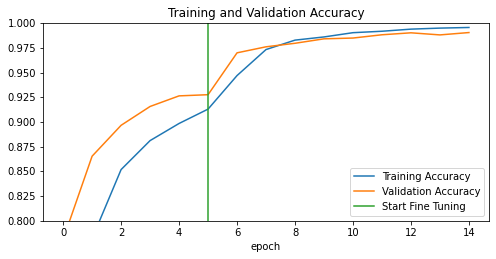

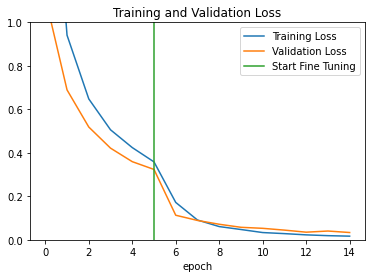

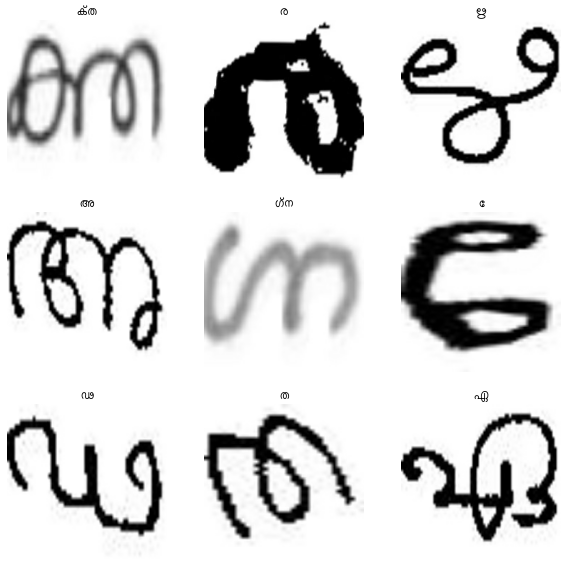

INFO:tensorflow:Assets written to: results\model_summary\densenet\13-14_30-3-2022-32_6_8\model_finetuned\assets


C:\Python39\lib\site-packages\docx\styles\styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


Model: vggnet
Epoch 1/6
689/689 [==============================] - 176s 251ms/step - loss: 2.5942 - accuracy: 0.4525 - val_loss: 0.6336 - val_accuracy: 0.8336
Epoch 2/6
689/689 [==============================] - 181s 262ms/step - loss: 0.6717 - accuracy: 0.8012 - val_loss: 0.3636 - val_accuracy: 0.9060
Epoch 3/6
689/689 [==============================] - 183s 266ms/step - loss: 0.4070 - accuracy: 0.8818 - val_loss: 0.2470 - val_accuracy: 0.9369
Epoch 4/6
689/689 [==============================] - 171s 248ms/step - loss: 0.2907 - accuracy: 0.9137 - val_loss: 0.2090 - val_accuracy: 0.9451
Epoch 5/6
689/689 [==============================] - 178s 259ms/step - loss: 0.2438 - accuracy: 0.9253 - val_loss: 0.1806 - val_accuracy: 0.9525
Epoch 6/6
59/59 [==============================] - 10s 161ms/step - loss: 0.1818 - accuracy: 0.9523
Loss: 0.18%
Accuracy: 95.23%
5
Epoch 6/14
689/689 [==============================] - 225s 324ms/step - loss: 0.1023 - accuracy: 0.9652 - val_loss: 0.0738 - val_a

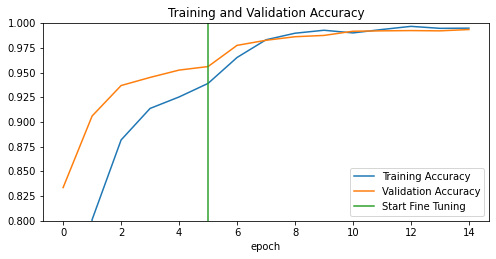

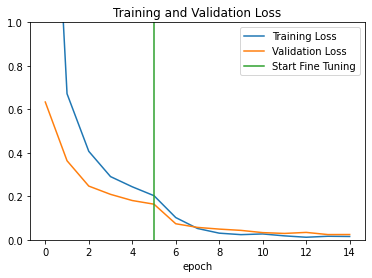

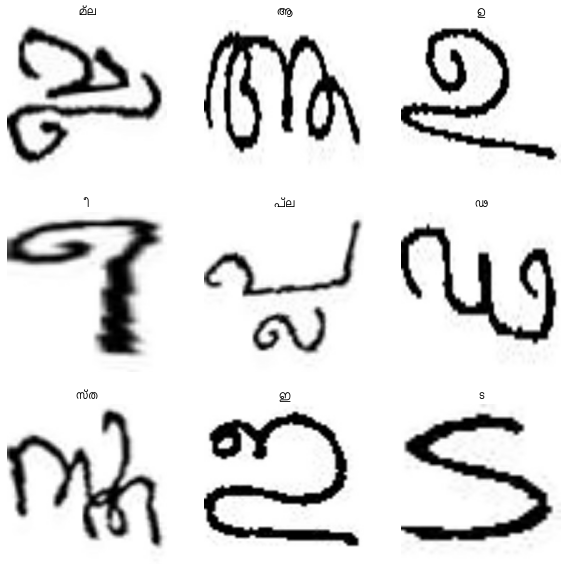

INFO:tensorflow:Assets written to: results\model_summary\vggnet\14-6_30-3-2022-32_6_8\model_finetuned\assets


C:\Python39\lib\site-packages\docx\styles\styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


Model: resnet
Epoch 1/6
689/689 [==============================] - 135s 192ms/step - loss: 1.5974 - accuracy: 0.6355 - val_loss: 0.6762 - val_accuracy: 0.8664
Epoch 2/6
689/689 [==============================] - 132s 191ms/step - loss: 0.5128 - accuracy: 0.8894 - val_loss: 0.4148 - val_accuracy: 0.9159
Epoch 3/6
689/689 [==============================] - 131s 190ms/step - loss: 0.3066 - accuracy: 0.9392 - val_loss: 0.3056 - val_accuracy: 0.9355
Epoch 4/6
689/689 [==============================] - 129s 188ms/step - loss: 0.2192 - accuracy: 0.9576 - val_loss: 0.2445 - val_accuracy: 0.9456
Epoch 5/6
689/689 [==============================] - 122s 177ms/step - loss: 0.1646 - accuracy: 0.9705 - val_loss: 0.2047 - val_accuracy: 0.9542
Epoch 6/6
59/59 [==============================] - 7s 103ms/step - loss: 0.2076 - accuracy: 0.9539
Loss: 0.21%
Accuracy: 95.39%
5
Epoch 6/14
689/689 [==============================] - 199s 281ms/step - loss: 0.0513 - accuracy: 0.9850 - val_loss: 0.0599 - val_ac

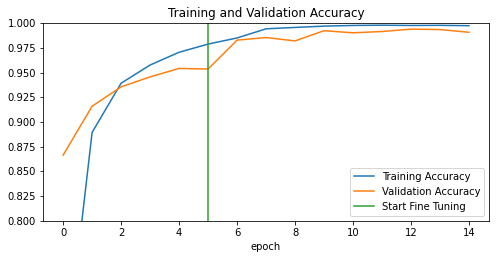

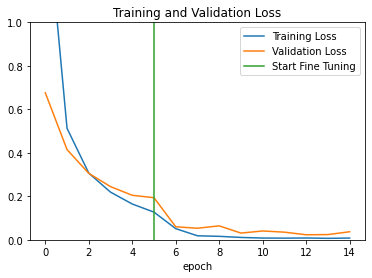

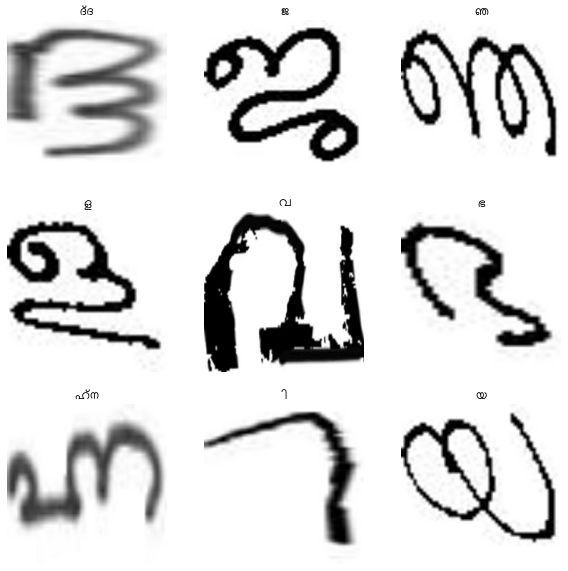

INFO:tensorflow:Assets written to: results\model_summary\resnet\14-48_30-3-2022-32_6_8\model_finetuned\assets


C:\Python39\lib\site-packages\docx\styles\styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


Model: inceptionresnet
Epoch 1/6
689/689 [==============================] - 217s 301ms/step - loss: 2.1715 - accuracy: 0.4771 - val_loss: 1.2289 - val_accuracy: 0.6934
Epoch 2/6
689/689 [==============================] - 202s 293ms/step - loss: 1.0228 - accuracy: 0.7336 - val_loss: 0.8437 - val_accuracy: 0.7875
Epoch 3/6
689/689 [==============================] - 200s 291ms/step - loss: 0.7333 - accuracy: 0.8093 - val_loss: 0.6648 - val_accuracy: 0.8351
Epoch 4/6
689/689 [==============================] - 201s 292ms/step - loss: 0.5795 - accuracy: 0.8468 - val_loss: 0.5742 - val_accuracy: 0.8513
Epoch 5/6
689/689 [==============================] - 202s 294ms/step - loss: 0.4838 - accuracy: 0.8731 - val_loss: 0.4995 - val_accuracy: 0.8659
Epoch 6/6
59/59 [==============================] - 12s 186ms/step - loss: 0.4713 - accuracy: 0.8718
Loss: 0.47%
Accuracy: 87.18%
5
Epoch 6/14
689/689 [==============================] - 305s 421ms/step - loss: 0.1807 - accuracy: 0.9482 - val_loss: 0.144

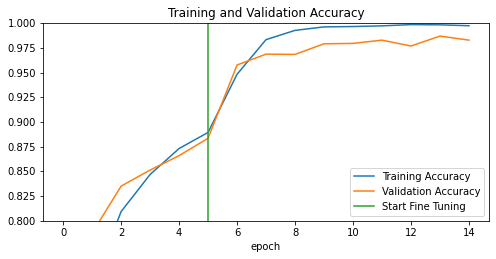

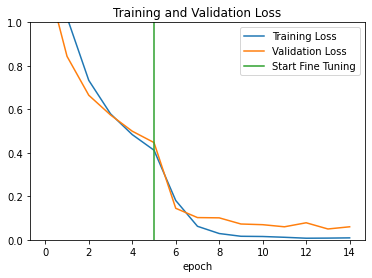

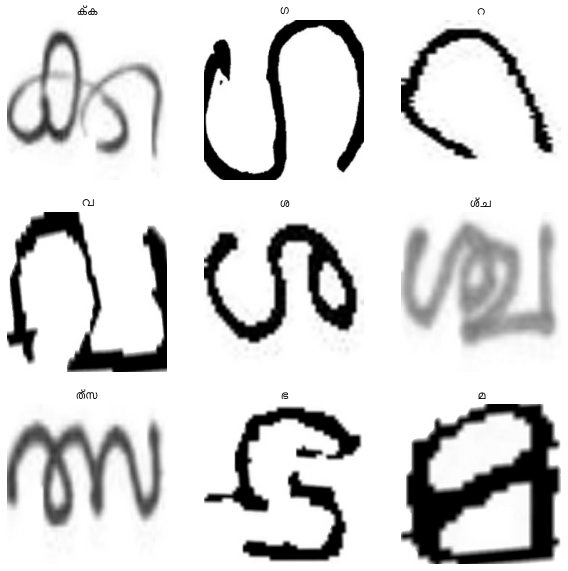

INFO:tensorflow:Assets written to: results\model_summary\inceptionresnet\15-52_30-3-2022-32_6_8\model_finetuned\assets


C:\Python39\lib\site-packages\docx\styles\styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


Model: efficientnet
Epoch 1/6
689/689 [==============================] - 152s 210ms/step - loss: 1.8091 - accuracy: 0.6258 - val_loss: 0.8654 - val_accuracy: 0.8398
Epoch 2/6
689/689 [==============================] - 135s 196ms/step - loss: 0.6455 - accuracy: 0.8783 - val_loss: 0.4987 - val_accuracy: 0.9122
Epoch 3/6
689/689 [==============================] - 136s 198ms/step - loss: 0.4001 - accuracy: 0.9284 - val_loss: 0.3518 - val_accuracy: 0.9406
Epoch 4/6
689/689 [==============================] - 137s 198ms/step - loss: 0.2838 - accuracy: 0.9535 - val_loss: 0.2734 - val_accuracy: 0.9530
Epoch 5/6
689/689 [==============================] - 136s 198ms/step - loss: 0.2150 - accuracy: 0.9685 - val_loss: 0.2226 - val_accuracy: 0.9608
Epoch 6/6
59/59 [==============================] - 7s 113ms/step - loss: 0.2149 - accuracy: 0.9513
Loss: 0.21%
Accuracy: 95.13%
5
Epoch 6/14
689/689 [==============================] - 193s 241ms/step - loss: 0.0824 - accuracy: 0.9838 - val_loss: 0.0979 - 

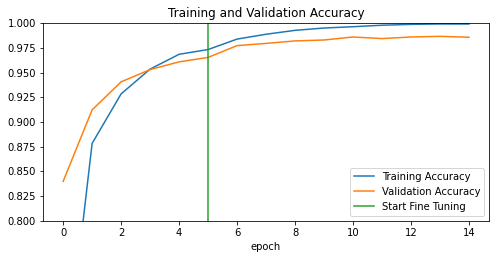

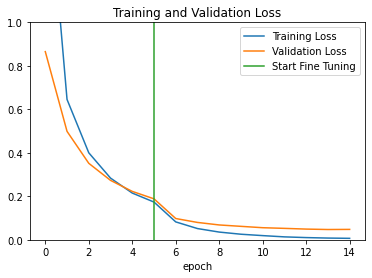

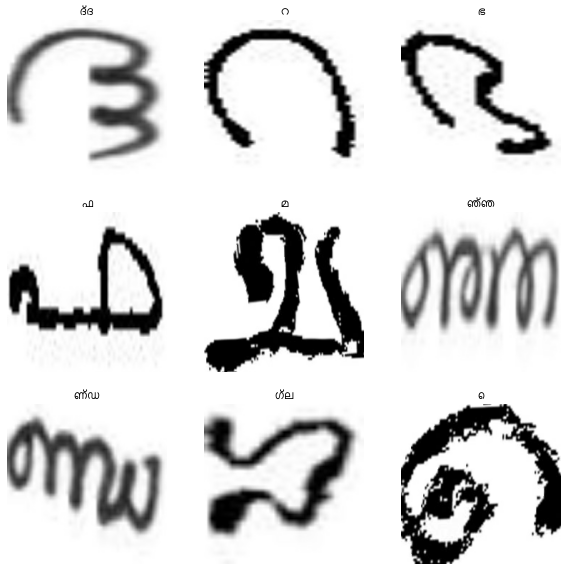

INFO:tensorflow:Assets written to: results\model_summary\efficientnet\16-33_30-3-2022-32_6_8\model_finetuned\assets


C:\Python39\lib\site-packages\docx\styles\styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


Model: inceptionnet
Epoch 1/6
689/689 [==============================] - 128s 176ms/step - loss: 1.6704 - accuracy: 0.6006 - val_loss: 0.7950 - val_accuracy: 0.8050
Epoch 2/6
689/689 [==============================] - 114s 165ms/step - loss: 0.6003 - accuracy: 0.8459 - val_loss: 0.5420 - val_accuracy: 0.8615
Epoch 3/6
689/689 [==============================] - 113s 164ms/step - loss: 0.3830 - accuracy: 0.9054 - val_loss: 0.4385 - val_accuracy: 0.8823
Epoch 4/6
689/689 [==============================] - 116s 168ms/step - loss: 0.2755 - accuracy: 0.9312 - val_loss: 0.3716 - val_accuracy: 0.8961
Epoch 5/6
689/689 [==============================] - 116s 169ms/step - loss: 0.2140 - accuracy: 0.9475 - val_loss: 0.3381 - val_accuracy: 0.9039
Epoch 6/6
59/59 [==============================] - 8s 113ms/step - loss: 0.3358 - accuracy: 0.9025
Loss: 0.34%
Accuracy: 90.25%
5
Epoch 6/14
689/689 [==============================] - 329s 466ms/step - loss: 0.0833 - accuracy: 0.9743 - val_loss: 0.1307 - 

In [ ]:
for model_config in models:
    basemodel = model_config['basemodel']
    preprocess_input = model_config['preprocess']
    name = model_config['name']
    fine_tune_at = model_config['finetune_at_layer']
    print(f"Model: {name}")
    
    # Normal training
    
    basemodel.trainable = False 
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = preprocess_input(inputs)
    x = basemodel(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs,name = f'{name}_model')
    lr = 0.001
    b1 = 0.9
    b2 = 0.999 
    ep = 1e-07
    checkpoint_filepath = f'models/checkpoints/{name}/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=b1,beta_2=b2, epsilon=ep, decay=0.0),
      loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy'])
    history = model.fit(
          train_ds,
          validation_data=val_ds,
              callbacks=[model_checkpoint_callback],
          epochs=NORMAL_EPOCHS
        )
    loss_p, accuracy = model.evaluate(test_dataset)
    accuracy = accuracy * 100
    print(f"Loss: {loss_p:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # FIne Tuning
    basemodel.trainable = True 
    for layer in basemodel.layers[:fine_tune_at]:
        layer.trainable =  False
    lr = 1e-05
    b1 = 0.9
    b2 = 0.999 
    ep = 1e-07
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=b1,beta_2=b2, epsilon=ep, decay=0.0),
      loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy'])
    total_epochs = NORMAL_EPOCHS + FINETUNE_EPOCHS
    print(history.epoch[-1])
    history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                        callbacks=[model_checkpoint_callback],
                         validation_data=val_ds)
    model.load_weights(checkpoint_filepath)
    loss_finetuned, accuracy_finetuned = model.evaluate(test_dataset)
    accuracy_finetuned = accuracy_finetuned * 100
    print('Test accuracy :', accuracy_finetuned)
    # Folder creation
    today = datetime.datetime.now()
    folder_name = f'{today.hour}-{today.minute}_{today.day:02d}-{today.month}-{today.year}-{BATCH_SIZE}_{NORMAL_EPOCHS}_{FINETUNE_EPOCHS}'
    path = os.path.join('results','model_summary',name,folder_name)
    if not os.path.exists(path):
        os.makedirs(path)
    model_folder = path
    
    # Performance metrics
    y_pred = model.predict(y_test)
    y_pred_bool = np.argmax(y_pred, axis=-1)
    clr = classification_report(y_true, y_pred_bool, target_names=class_names, output_dict=True)
    report = pd.DataFrame(clr).transpose()
    report.to_html(model_folder+'\\metrics.html')
    report.to_csv(model_folder+'\\metrics.csv')
    
    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']

    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.8, 1])
    plt.plot([NORMAL_EPOCHS-1,NORMAL_EPOCHS-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    plt.savefig(model_folder+'\\accuracy.png')
    plt.show()

    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([NORMAL_EPOCHS-1,NORMAL_EPOCHS-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.savefig(model_folder+'\\loss.png')
    plt.show()
    
    pickle.dump(history_fine.history, open(model_folder+'\\history_fine.pickle', 'wb'))
    f = open(model_folder+"\\config.txt", "w")
    f.writelines([f'Batch" {BATCH_SIZE}\n',f'Classes: {NUM_CLASSES}',f'normal epochs:{NORMAL_EPOCHS}\n',f'tuned epochs:{FINETUNE_EPOCHS}\n',f'accuracy: {accuracy}\n',f'accuracy finetuned: {accuracy_finetuned}\n'])
    f.close()
    image_batch, label_batch = test_dataset.as_numpy_iterator().next()
    predictions = model.predict_on_batch(image_batch)
    predictions = predictions.argmax(axis=-1)
    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      pred_word = predict_word(predictions[i])
      plt.title(pred_word,fontproperties=mal_font)
      plt.axis("off")
    plt.savefig(model_folder+'\\prediction.png')
    plt.show()
    
    model.save(model_folder+f'\\model_finetuned')
    config = {
    'report': report,
    'batch':BATCH_SIZE,
    'normal_epoch':NORMAL_EPOCHS,
    'finetuned_epoch':FINETUNE_EPOCHS,
        
    }
    generate_doc(model_folder,name,config)
    
    

    
    
    
    
    